# Creator suggestion for influencer sponsorship

## Part 4: ZeroShot Modelling, Feature Engineering on categorical columns
---

### Content Workflow:
- [Instatiate libraries](#Instatiate-libraries)
- [Loading of datasets](#Loading-of-datasets)
- [Feature engineering on zeroshot](#Feature-engineering-on-zeroshot)
- [Zero-shot analysis on the video topics](#Zero-shot-analysis-on-the-video-topics)
- [Conclusion and Recommendation](#Conclusion-and-Recommendation)

# Instatiate libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import datetime as dt
import emoji
import demoji
import regex as re

# Import progress bar
from tqdm.notebook import tqdm_notebook
tqdm_notebook.pandas()

# Removal of stopwords
from nltk.tokenize import RegexpTokenizer
import emoji
import demoji
import numpy as np
import regex as re

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Huggingface model
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import pipeline

# Expand display of the dataframe
pd.options.display.max_colwidth = 500

import warnings
warnings.filterwarnings("ignore")

## Loading-of-datasets

In [7]:
### Save the items into csv
#df.to_csv('./output/eda_df_token.csv')
# yt_df1.to_csv('./output/eda_yt_df1.csv')
#ch_df.to_csv('./output/eda_ch_info.csv')
### Load Saved datasets
df_gl0 = pd.read_csv('./output/Golden_Labels_(ZS).csv')
df_gl = pd.read_csv('./output/Golden_Labels_(ZS)_ul.csv')
#zs_title= pd.read_csv('./output/eda_df_title_zero_shot_prd.csv')
df_tok=pd.read_csv('./output/eda_df_tokenize.csv')
#yt_df1 = pd.read_csv('./output/eda_yt_df1.csv')
#ch_df = pd.read_csv('./output/eda_ch_info.csv')

## Feature engineering on zeroshot
---
Besides determining model btween the text data within the 'Title' column, anthor feature engineering on the text data is to classify the models using the pre-trained model on huggingface into pre-determined labelled topics.

Firstly the labelled dataset tested on multiple model combinations to obtain the best model which we will the entire dataset in.

## Zero-shot analysis on the video topics

### Selection of zero-shot model (multi-label= False)

In [25]:
df_gl.replace(np.nan,0, inplace=True)

In [26]:
df_gl.columns
df_gl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Index            100 non-null    int64  
 1   Title            100 non-null    object 
 2   Channel_name     100 non-null    object 
 3   tokens           100 non-null    object 
 4   topic            100 non-null    int64  
 5   Coding (COD)     100 non-null    float64
 6   Lifestyle (LIF)  100 non-null    float64
 7   Education (EDU)  100 non-null    float64
 8   Jobs(JOB)        100 non-null    int64  
 9   Top              100 non-null    object 
dtypes: float64(3), int64(3), object(4)
memory usage: 7.9+ KB


In [27]:
# Convert float to int 
df_gl['Coding (COD)'] = df_gl['Coding (COD)'].astype(int)
df_gl['Lifestyle (LIF)'] = df_gl['Lifestyle (LIF)'].astype(int)
df_gl['Education (EDU)'] = df_gl['Education (EDU)'].astype(int)

In [28]:
df_gl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Index            100 non-null    int64 
 1   Title            100 non-null    object
 2   Channel_name     100 non-null    object
 3   tokens           100 non-null    object
 4   topic            100 non-null    int64 
 5   Coding (COD)     100 non-null    int32 
 6   Lifestyle (LIF)  100 non-null    int32 
 7   Education (EDU)  100 non-null    int32 
 8   Jobs(JOB)        100 non-null    int64 
 9   Top              100 non-null    object
dtypes: int32(3), int64(3), object(4)
memory usage: 6.8+ KB


In [29]:
# Combine matrix for the topics
df_gl['matrix'] = df_gl.pop('Coding (COD)').astype(str) + ',' + df_gl.pop('Lifestyle (LIF)').astype(str) + "," + df_gl.pop('Education (EDU)').astype(str) +"," + df_gl.pop('Jobs(JOB)').astype(str)

In [30]:
df_gl.head()

,Index,Title,Channel_name,tokens,topic,Top,matrix
0,9208,OpenDaylight (ODL) and Mininet demo - SDN & OpenFlow on GNS3,David Bombal,"['opendaylight', 'odl', 'mininet', 'demo', 'sdn', 'openflow']",0,cod,"1,0,0,0"
1,12927,Perform EDA In Seconds With Visualization Using SweetViz Library,Krish Naik,"['perform', 'eda', 'seconds', 'visualization', 'sweetviz', 'library']",0,cod,"1,0,0,0"
2,12410,Integrating HTML With FLASK Web Framework With HTTP VERBS(Get And POST),Krish Naik,"['integrate', 'html', 'flask', 'web', 'framework', 'http', 'post']",0,cod,"1,0,0,0"
3,12822,Silhouette (clustering)- Validating Clustering Models- Unsupervised Machine Learning,Krish Naik,"['silhouette', 'validate', 'cluster', 'unsupervised', 'machine', 'learning']",0,cod,"1,0,0,0"
4,13744,Why the Sky ISN'T Blue,Veritasium,"['sky', 'blue']",0,lif,"0,1,0,0"


In the following model evaluation 2 models are used in the evaluation of zero-shot. The models are bart-large-mnli and cross-encoder/nli-distilroberta-base. The topics are encoded into matrices on the labelled dataset and is compared to the labelled dataset for multi-label and uni-labelled.

### Zero-shot on labelled data using model 1(bart-large-mnli)

In [13]:
model_name = "facebook/bart-large-mnli"
model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

classifier = pipeline("zero-shot-classification",
                      model= model, tokenizer=tokenizer)

In [76]:
# Loading of dataframe
#zs_res = pd.read_pickle('./output/df_gl_title_zero_shot.pkl')

In [78]:
#zs_res = zs_res.drop(['Coding', 'Productivity', 'Lifestyle', 'Education'], axis=1)

In [14]:
def zero_shot_result(row):
    return {
            f'zero_shot_pred_{label}': score
            for label, score in zip(row['label'], row['scores']) 
    }
def zero_shot_preds(df, model, classifier, topic_list, multi_label):
    df['zero_shot_output' + model] = df['Title'].progress_apply(classifier, candidate_labels=topic_list,
                                                       multi_label=multi_label)
    zero_shot_df = pd.json_normalize(df['zero_shot_output'+ model])
    df['labels'+ model] = df['zero_shot_output'  + model].apply(pd.Series)['labels']
    df['scores'+ model] = df['zero_shot_output' + model].apply(pd.Series)['scores']
    return df

In [15]:
topic_list = ['coding', 'lifestyle', 'education','job']

In [31]:
zero_shot_preds(df_gl, '_mod1', classifier, topic_list, multi_label=False)

  0%|          | 0/100 [00:00<?, ?it/s]

,Index,Title,Channel_name,tokens,topic,Top,matrix,zero_shot_output_mod1,labels_mod1,scores_mod1
0,9208,OpenDaylight (ODL) and Mininet demo - SDN & OpenFlow on GNS3,David Bombal,"['opendaylight', 'odl', 'mininet', 'demo', 'sdn', 'openflow']",0,cod,"1,0,0,0","{'sequence': 'OpenDaylight (ODL) and Mininet demo - SDN & OpenFlow on GNS3', 'labels': ['coding', 'job', 'lifestyle', 'education'], 'scores': [0.4036387801170349, 0.3224651515483856, 0.19542500376701355, 0.0784710943698883]}","[coding, job, lifestyle, education]","[0.4036387801170349, 0.3224651515483856, 0.19542500376701355, 0.0784710943698883]"
1,12927,Perform EDA In Seconds With Visualization Using SweetViz Library,Krish Naik,"['perform', 'eda', 'seconds', 'visualization', 'sweetviz', 'library']",0,cod,"1,0,0,0","{'sequence': 'Perform EDA In Seconds With Visualization Using SweetViz Library', 'labels': ['education', 'job', 'coding', 'lifestyle'], 'scores': [0.576435387134552, 0.305303692817688, 0.06086362898349762, 0.05739726126194]}","[education, job, coding, lifestyle]","[0.576435387134552, 0.305303692817688, 0.06086362898349762, 0.05739726126194]"
2,12410,Integrating HTML With FLASK Web Framework With HTTP VERBS(Get And POST),Krish Naik,"['integrate', 'html', 'flask', 'web', 'framework', 'http', 'post']",0,cod,"1,0,0,0","{'sequence': 'Integrating HTML With FLASK Web Framework With HTTP VERBS(Get And POST)', 'labels': ['coding', 'job', 'lifestyle', 'education'], 'scores': [0.48485395312309265, 0.315927118062973, 0.16821669042110443, 0.031002234667539597]}","[coding, job, lifestyle, education]","[0.48485395312309265, 0.315927118062973, 0.16821669042110443, 0.031002234667539597]"
3,12822,Silhouette (clustering)- Validating Clustering Models- Unsupervised Machine Learning,Krish Naik,"['silhouette', 'validate', 'cluster', 'unsupervised', 'machine', 'learning']",0,cod,"1,0,0,0","{'sequence': 'Silhouette (clustering)- Validating Clustering Models- Unsupervised Machine Learning', 'labels': ['job', 'coding', 'lifestyle', 'education'], 'scores': [0.6587124466896057, 0.15925385057926178, 0.11581628769636154, 0.06621742993593216]}","[job, coding, lifestyle, education]","[0.6587124466896057, 0.15925385057926178, 0.11581628769636154, 0.06621742993593216]"
4,13744,Why the Sky ISN'T Blue,Veritasium,"['sky', 'blue']",0,lif,"0,1,0,0","{'sequence': 'Why the Sky ISN'T Blue', 'labels': ['job', 'coding', 'education', 'lifestyle'], 'scores': [0.3183000087738037, 0.2994384467601776, 0.1958949863910675, 0.18636658787727356]}","[job, coding, education, lifestyle]","[0.3183000087738037, 0.2994384467601776, 0.1958949863910675, 0.18636658787727356]"
...,...,...,...,...,...,...,...,...,...,...
95,14142,Exploratory Data Analysis in R: Towards Data Understanding,Data Professor,"['exploratory', 'data', 'analysis', 'r', 'datum', 'understanding']",4,cod,"1,0,0,0","{'sequence': 'Exploratory Data Analysis in R: Towards Data Understanding', 'labels': ['job', 'coding', 'education', 'lifestyle'], 'scores': [0.6553198099136353, 0.20956146717071533, 0.0695311576128006, 0.0655875876545906]}","[job, coding, education, lifestyle]","[0.6553198099136353, 0.20956146717071533, 0.0695311576128006, 0.0655875876545906]"
96,5436,I used the GPT-2 AI to respond to my YouTube comments,Aaron Jack / Freemote,"['ai', 'respond', 'youtube', 'comment']",4,cod,"1,0,0,0","{'sequence': 'I used the GPT-2 AI to respond to my YouTube comments', 'labels': ['job', 'lifestyle', 'coding', 'education'], 'scores': [0.5327465534210205, 0.2728555500507355, 0.12655186653137207, 0.06784598529338837]}","[job, lifestyle, coding, education]","[0.5327465534210205, 0.2728555500507355, 0.12655186653137207, 0.06784598529338837]"
97,13154,Tutorial 6- Data Transformation Using QlikSense,Krish Naik,"['tutorial', 'data', 'transformation', 'qliksense']",4,cod,"1,0,0,0","{'sequence': 'Tutorial 6- Data Transformation Using QlikSense', 'labels': ['job', 'coding', 'education', 'lifestyle'], 'scores': [0.3782288730144501, 0.36209267377853394, 0.1740514189004898,

### Zero-shot on labelled data using model 1(cross-encoder/nli-distilroberta-base)

In [32]:
model_name = "cross-encoder/nli-distilroberta-base"
model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

classifier1 = pipeline("zero-shot-classification",
                      model= model, tokenizer=tokenizer)

In [33]:
zero_shot_preds(df_gl, '_mod2', classifier1, topic_list, multi_label=False)

  0%|          | 0/100 [00:00<?, ?it/s]

,Index,Title,Channel_name,tokens,topic,Top,matrix,zero_shot_output_mod1,labels_mod1,scores_mod1,zero_shot_output_mod2,labels_mod2,scores_mod2
0,9208,OpenDaylight (ODL) and Mininet demo - SDN & OpenFlow on GNS3,David Bombal,"['opendaylight', 'odl', 'mininet', 'demo', 'sdn', 'openflow']",0,cod,"1,0,0,0","{'sequence': 'OpenDaylight (ODL) and Mininet demo - SDN & OpenFlow on GNS3', 'labels': ['coding', 'job', 'lifestyle', 'education'], 'scores': [0.4036387801170349, 0.3224651515483856, 0.19542500376701355, 0.0784710943698883]}","[coding, job, lifestyle, education]","[0.4036387801170349, 0.3224651515483856, 0.19542500376701355, 0.0784710943698883]","{'sequence': 'OpenDaylight (ODL) and Mininet demo - SDN & OpenFlow on GNS3', 'labels': ['coding', 'job', 'lifestyle', 'education'], 'scores': [0.5202033519744873, 0.18737168610095978, 0.17511363327503204, 0.11731134355068207]}","[coding, job, lifestyle, education]","[0.5202033519744873, 0.18737168610095978, 0.17511363327503204, 0.11731134355068207]"
1,12927,Perform EDA In Seconds With Visualization Using SweetViz Library,Krish Naik,"['perform', 'eda', 'seconds', 'visualization', 'sweetviz', 'library']",0,cod,"1,0,0,0","{'sequence': 'Perform EDA In Seconds With Visualization Using SweetViz Library', 'labels': ['education', 'job', 'coding', 'lifestyle'], 'scores': [0.576435387134552, 0.305303692817688, 0.06086362898349762, 0.05739726126194]}","[education, job, coding, lifestyle]","[0.576435387134552, 0.305303692817688, 0.06086362898349762, 0.05739726126194]","{'sequence': 'Perform EDA In Seconds With Visualization Using SweetViz Library', 'labels': ['coding', 'job', 'lifestyle', 'education'], 'scores': [0.8310244083404541, 0.07826890051364899, 0.04634581133723259, 0.044360898435115814]}","[coding, job, lifestyle, education]","[0.8310244083404541, 0.07826890051364899, 0.04634581133723259, 0.044360898435115814]"
2,12410,Integrating HTML With FLASK Web Framework With HTTP VERBS(Get And POST),Krish Naik,"['integrate', 'html', 'flask', 'web', 'framework', 'http', 'post']",0,cod,"1,0,0,0","{'sequence': 'Integrating HTML With FLASK Web Framework With HTTP VERBS(Get And POST)', 'labels': ['coding', 'job', 'lifestyle', 'education'], 'scores': [0.48485395312309265, 0.315927118062973, 0.16821669042110443, 0.031002234667539597]}","[coding, job, lifestyle, education]","[0.48485395312309265, 0.315927118062973, 0.16821669042110443, 0.031002234667539597]","{'sequence': 'Integrating HTML With FLASK Web Framework With HTTP VERBS(Get And POST)', 'labels': ['coding', 'job', 'lifestyle', 'education'], 'scores': [0.8250558972358704, 0.07942847907543182, 0.06879658252000809, 0.02671901509165764]}","[coding, job, lifestyle, education]","[0.8250558972358704, 0.07942847907543182, 0.06879658252000809, 0.02671901509165764]"
3,12822,Silhouette (clustering)- Validating Clustering Models- Unsupervised Machine Learning,Krish Naik,"['silhouette', 'validate', 'cluster', 'unsupervised', 'machine', 'learning']",0,cod,"1,0,0,0","{'sequence': 'Silhouette (clustering)- Validating Clustering Models- Unsupervised Machine Learning', 'labels': ['job', 'coding', 'lifestyle', 'education'], 'scores': [0.6587124466896057, 0.15925385057926178, 0.11581628769636154, 0.06621742993593216]}","[job, coding, lifestyle, education]","[0.6587124466896057, 0.15925385057926178, 0.11581628769636154, 0.06621742993593216]","{'sequence': 'Silhouette (clustering)- Validating Clustering Models- Unsupervised Machine Learning', 'labels': ['coding', 'job', 'education', 'lifestyle'], 'scores': [0.6187117695808411, 0.17410677671432495, 0.11593084037303925, 0.09125058352947235]}","[coding, job, education, lifestyle]","[0.6187117695808411, 0.17410677671432495, 0.11593084037303925, 0.09125058352947235]"
4,13744,Why the Sky ISN'T Blue,Veritasium,"['sky', 'blue']",0,lif,"0,1,0,0","{'sequence': 'Why the Sky ISN'T Blue', 'labels': ['job', 'coding', 'education', 'lifestyle'], 'scores': [0.3183000087738037, 0.2994384467601776, 0.1958949863910675, 0.18636658787727356]

In [14]:
### When multi-class = False
def get_matrix_mf(df, col1, col2, col3):
    ### Encode scores to 1s and 0s.
    m_mod1 = []
    for i in df[col1].tolist():
        matrix = [1 if x==0 else 0 for x in range(len(i))]
        m_mod1.append(matrix)

    ### Reorder the list of labels
    order_l = ['coding', 'lifestyle', 'education', 'job']

    ### Zip labels to scores.
    data0 = df[col2].tolist()
    bins = []
    for l,s in zip(data0,m_mod1):
        zipped = dict(zip(l,s))
        item = {k: zipped[k] for k in order_l}
        bins.append(item)
    bins[:5]
    
    # Matrix for model 1 
    data = pd.DataFrame.from_dict(bins, orient='columns')
    df[col3] = data.pop('coding').astype(str) + ',' + data.pop('lifestyle').astype(str) + "," + data.pop('education').astype(str) +"," + data.pop('job').astype(str)
    return df.tail(3)

In [36]:
get_matrix_mf(df_gl, 'scores_mod1', 'labels_mod1', 'matrix_m1')

,Index,Title,Channel_name,tokens,topic,Top,matrix,zero_shot_output_mod1,labels_mod1,scores_mod1,zero_shot_output_mod2,labels_mod2,scores_mod2,matrix_m1
97,13154,Tutorial 6- Data Transformation Using QlikSense,Krish Naik,"['tutorial', 'data', 'transformation', 'qliksense']",4,cod,"1,0,0,0","{'sequence': 'Tutorial 6- Data Transformation Using QlikSense', 'labels': ['job', 'coding', 'education', 'lifestyle'], 'scores': [0.3782288730144501, 0.36209267377853394, 0.1740514189004898, 0.08562703430652618]}","[job, coding, education, lifestyle]","[0.3782288730144501, 0.36209267377853394, 0.1740514189004898, 0.08562703430652618]","{'sequence': 'Tutorial 6- Data Transformation Using QlikSense', 'labels': ['coding', 'education', 'job', 'lifestyle'], 'scores': [0.44326555728912354, 0.25601503252983093, 0.20104190707206726, 0.09967750310897827]}","[coding, education, job, lifestyle]","[0.44326555728912354, 0.25601503252983093, 0.20104190707206726, 0.09967750310897827]","0,0,0,1"
98,9799,I Left my Job at Google - Here's Why,Clément Mihailescu,"['leave', 'job', 'google']",4,job,"0,1,0,1","{'sequence': 'I Left my Job at Google - Here's Why', 'labels': ['job', 'lifestyle', 'coding', 'education'], 'scores': [0.9838376045227051, 0.006449170410633087, 0.006226178724318743, 0.003487010719254613]}","[job, lifestyle, coding, education]","[0.9838376045227051, 0.006449170410633087, 0.006226178724318743, 0.003487010719254613]","{'sequence': 'I Left my Job at Google - Here's Why', 'labels': ['job', 'lifestyle', 'coding', 'education'], 'scores': [0.8858247399330139, 0.04666057229042053, 0.04404605180025101, 0.023468676954507828]}","[job, lifestyle, coding, education]","[0.8858247399330139, 0.04666057229042053, 0.04404605180025101, 0.023468676954507828]","0,0,0,1"
99,12265,Reviewing Mechanical Engineer Resume For Data Science Role,Krish Naik,"['review', 'mechanical', 'engineer', 'resume', 'data', 'science', 'role']",4,job,"0,1,1,1","{'sequence': 'Reviewing Mechanical Engineer Resume For Data Science Role', 'labels': ['job', 'coding', 'education', 'lifestyle'], 'scores': [0.9396694898605347, 0.038424015045166016, 0.013408014550805092, 0.008498475886881351]}","[job, coding, education, lifestyle]","[0.9396694898605347, 0.038424015045166016, 0.013408014550805092, 0.008498475886881351]","{'sequence': 'Reviewing Mechanical Engineer Resume For Data Science Role', 'labels': ['job', 'coding', 'lifestyle', 'education'], 'scores': [0.909476637840271, 0.03325865790247917, 0.03157377615571022, 0.02569091133773327]}","[job, coding, lifestyle, education]","[0.909476637840271, 0.03325865790247917, 0.03157377615571022, 0.02569091133773327]","0,0,0,1"


In [38]:
get_matrix_mf(df_gl, 'scores_mod2', 'labels_mod2', 'matrix_m2')

,Index,Title,Channel_name,tokens,topic,Top,matrix,zero_shot_output_mod1,labels_mod1,scores_mod1,zero_shot_output_mod2,labels_mod2,scores_mod2,matrix_m1,matrix_m2
97,13154,Tutorial 6- Data Transformation Using QlikSense,Krish Naik,"['tutorial', 'data', 'transformation', 'qliksense']",4,cod,"1,0,0,0","{'sequence': 'Tutorial 6- Data Transformation Using QlikSense', 'labels': ['job', 'coding', 'education', 'lifestyle'], 'scores': [0.3782288730144501, 0.36209267377853394, 0.1740514189004898, 0.08562703430652618]}","[job, coding, education, lifestyle]","[0.3782288730144501, 0.36209267377853394, 0.1740514189004898, 0.08562703430652618]","{'sequence': 'Tutorial 6- Data Transformation Using QlikSense', 'labels': ['coding', 'education', 'job', 'lifestyle'], 'scores': [0.44326555728912354, 0.25601503252983093, 0.20104190707206726, 0.09967750310897827]}","[coding, education, job, lifestyle]","[0.44326555728912354, 0.25601503252983093, 0.20104190707206726, 0.09967750310897827]","0,0,0,1","1,0,0,0"
98,9799,I Left my Job at Google - Here's Why,Clément Mihailescu,"['leave', 'job', 'google']",4,job,"0,1,0,1","{'sequence': 'I Left my Job at Google - Here's Why', 'labels': ['job', 'lifestyle', 'coding', 'education'], 'scores': [0.9838376045227051, 0.006449170410633087, 0.006226178724318743, 0.003487010719254613]}","[job, lifestyle, coding, education]","[0.9838376045227051, 0.006449170410633087, 0.006226178724318743, 0.003487010719254613]","{'sequence': 'I Left my Job at Google - Here's Why', 'labels': ['job', 'lifestyle', 'coding', 'education'], 'scores': [0.8858247399330139, 0.04666057229042053, 0.04404605180025101, 0.023468676954507828]}","[job, lifestyle, coding, education]","[0.8858247399330139, 0.04666057229042053, 0.04404605180025101, 0.023468676954507828]","0,0,0,1","0,0,0,1"
99,12265,Reviewing Mechanical Engineer Resume For Data Science Role,Krish Naik,"['review', 'mechanical', 'engineer', 'resume', 'data', 'science', 'role']",4,job,"0,1,1,1","{'sequence': 'Reviewing Mechanical Engineer Resume For Data Science Role', 'labels': ['job', 'coding', 'education', 'lifestyle'], 'scores': [0.9396694898605347, 0.038424015045166016, 0.013408014550805092, 0.008498475886881351]}","[job, coding, education, lifestyle]","[0.9396694898605347, 0.038424015045166016, 0.013408014550805092, 0.008498475886881351]","{'sequence': 'Reviewing Mechanical Engineer Resume For Data Science Role', 'labels': ['job', 'coding', 'lifestyle', 'education'], 'scores': [0.909476637840271, 0.03325865790247917, 0.03157377615571022, 0.02569091133773327]}","[job, coding, lifestyle, education]","[0.909476637840271, 0.03325865790247917, 0.03157377615571022, 0.02569091133773327]","0,0,0,1","0,0,0,1"


In [39]:
correct_pred_cnt0 = sum(df_gl['matrix']==df_gl['matrix_m1'])
print(f"model_1 accuracy: {correct_pred_cnt0/df_gl['matrix'].count()}")

correct_pred_cnt1 = sum(df_gl['matrix']==df_gl['matrix_m2'])
print(f"model_2 accuracy: {correct_pred_cnt1/df_gl['matrix'].count()}")

model_1 accuracy: 0.34
model_2 accuracy: 0.55


## Selection of zero-shot model (multi-label= True)

In [40]:
df_gl0.replace(np.nan,0, inplace=True)

In [41]:
print(df_gl0.shape)
df_gl0.info()

(100, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Index               100 non-null    int64  
 1   Title               100 non-null    object 
 2   Channel_name        100 non-null    object 
 3   tokens              100 non-null    object 
 4   topic               100 non-null    int64  
 5   Coding (COD)        100 non-null    float64
 6   Productivity (PRO)  100 non-null    float64
 7   Lifestyle (LIF)     100 non-null    float64
 8   Education (EDU)     100 non-null    float64
 9   Jobs(JOB)           100 non-null    int64  
dtypes: float64(4), int64(3), object(3)
memory usage: 7.9+ KB


In [43]:
# Convert float to int 
df_gl0['Coding (COD)'] = df_gl0['Coding (COD)'].astype(int)
df_gl0['Lifestyle (LIF)'] = df_gl0['Lifestyle (LIF)'].astype(int)
df_gl0['Education (EDU)'] = df_gl0['Education (EDU)'].astype(int)

In [45]:
# Combine matrix for the topics
df_gl0['matrix'] = df_gl0.pop('Coding (COD)').astype(str) + ',' + df_gl0.pop('Lifestyle (LIF)').astype(str) + "," + df_gl0.pop('Education (EDU)').astype(str) +"," + df_gl0.pop('Jobs(JOB)').astype(str)

### Zero-shot on labelled data using model 1(bart-large-mnli)

In [46]:
zero_shot_preds(df_gl0,'mod',classifier, topic_list, multi_label=True)

  0%|          | 0/100 [00:00<?, ?it/s]

,Index,Title,Channel_name,tokens,topic,Productivity (PRO),matrix,zero_shot_outputmod,labelsmod,scoresmod
0,9208,OpenDaylight (ODL) and Mininet demo - SDN & OpenFlow on GNS3,David Bombal,"['opendaylight', 'odl', 'mininet', 'demo', 'sdn', 'openflow']",0,0.0,"1,0,0,0","{'sequence': 'OpenDaylight (ODL) and Mininet demo - SDN & OpenFlow on GNS3', 'labels': ['coding', 'job', 'lifestyle', 'education'], 'scores': [0.3558431565761566, 0.13464969396591187, 0.09072083234786987, 0.06684362888336182]}","[coding, job, lifestyle, education]","[0.3558431565761566, 0.13464969396591187, 0.09072083234786987, 0.06684362888336182]"
1,12927,Perform EDA In Seconds With Visualization Using SweetViz Library,Krish Naik,"['perform', 'eda', 'seconds', 'visualization', 'sweetviz', 'library']",0,0.0,"1,0,0,0","{'sequence': 'Perform EDA In Seconds With Visualization Using SweetViz Library', 'labels': ['education', 'job', 'lifestyle', 'coding'], 'scores': [0.8752310276031494, 0.46766334772109985, 0.17778466641902924, 0.0016949936980381608]}","[education, job, lifestyle, coding]","[0.8752310276031494, 0.46766334772109985, 0.17778466641902924, 0.0016949936980381608]"
2,12410,Integrating HTML With FLASK Web Framework With HTTP VERBS(Get And POST),Krish Naik,"['integrate', 'html', 'flask', 'web', 'framework', 'http', 'post']",0,0.0,"1,0,0,0","{'sequence': 'Integrating HTML With FLASK Web Framework With HTTP VERBS(Get And POST)', 'labels': ['coding', 'lifestyle', 'job', 'education'], 'scores': [0.7391538619995117, 0.5123517513275146, 0.5102193355560303, 0.03864334896206856]}","[coding, lifestyle, job, education]","[0.7391538619995117, 0.5123517513275146, 0.5102193355560303, 0.03864334896206856]"
3,12822,Silhouette (clustering)- Validating Clustering Models- Unsupervised Machine Learning,Krish Naik,"['silhouette', 'validate', 'cluster', 'unsupervised', 'machine', 'learning']",0,0.0,"1,0,0,0","{'sequence': 'Silhouette (clustering)- Validating Clustering Models- Unsupervised Machine Learning', 'labels': ['job', 'lifestyle', 'education', 'coding'], 'scores': [0.28627777099609375, 0.020910171791911125, 0.007553317118436098, 0.002449721796438098]}","[job, lifestyle, education, coding]","[0.28627777099609375, 0.020910171791911125, 0.007553317118436098, 0.002449721796438098]"
4,13744,Why the Sky ISN'T Blue,Veritasium,"['sky', 'blue']",0,0.0,"0,1,0,0","{'sequence': 'Why the Sky ISN'T Blue', 'labels': ['coding', 'lifestyle', 'education', 'job'], 'scores': [0.01672271452844143, 0.008724544197320938, 0.005557208321988583, 0.003315749578177929]}","[coding, lifestyle, education, job]","[0.01672271452844143, 0.008724544197320938, 0.005557208321988583, 0.003315749578177929]"
...,...,...,...,...,...,...,...,...,...,...
95,14142,Exploratory Data Analysis in R: Towards Data Understanding,Data Professor,"['exploratory', 'data', 'analysis', 'r', 'datum', 'understanding']",4,0.0,"1,0,0,0","{'sequence': 'Exploratory Data Analysis in R: Towards Data Understanding', 'labels': ['job', 'lifestyle', 'coding', 'education'], 'scores': [0.34312018752098083, 0.04774918034672737, 0.02102692984044552, 0.004991062916815281]}","[job, lifestyle, coding, education]","[0.34312018752098083, 0.04774918034672737, 0.02102692984044552, 0.004991062916815281]"
96,5436,I used the GPT-2 AI to respond to my YouTube comments,Aaron Jack / Freemote,"['ai', 'respond', 'youtube', 'comment']",4,0.0,"1,0,0,0","{'sequence': 'I used the GPT-2 AI to respond to my YouTube comments', 'labels': ['job', 'lifestyle', 'coding', 'education'], 'scores': [0.2817915380001068, 0.23563547432422638, 0.0075660101138055325, 0.004095801617950201]}","[job, lifestyle, coding, education]","[0.2817915380001068, 0.23563547432422638, 0.0075660101138055325, 0.004095801617950201]"
97,13154,Tutorial 6- Data Transformation Using QlikSense,Krish Naik,"['tutorial', 'data', 'transformation', 'qliksense']",4,0.0,"1,0,0,0","{'sequence': 'Tutorial 6- Data Transformation Using QlikSense', 'labels': ['job', 'lifestyle', 'coding', 'education'], 'scores': 

In [47]:
zero_shot_preds(df_gl0,'mod2',classifier1, topic_list, multi_label=True)

  0%|          | 0/100 [00:00<?, ?it/s]

,Index,Title,Channel_name,tokens,topic,Productivity (PRO),matrix,zero_shot_outputmod,labelsmod,scoresmod,zero_shot_outputmod2,labelsmod2,scoresmod2
0,9208,OpenDaylight (ODL) and Mininet demo - SDN & OpenFlow on GNS3,David Bombal,"['opendaylight', 'odl', 'mininet', 'demo', 'sdn', 'openflow']",0,0.0,"1,0,0,0","{'sequence': 'OpenDaylight (ODL) and Mininet demo - SDN & OpenFlow on GNS3', 'labels': ['coding', 'job', 'lifestyle', 'education'], 'scores': [0.3558431565761566, 0.13464969396591187, 0.09072083234786987, 0.06684362888336182]}","[coding, job, lifestyle, education]","[0.3558431565761566, 0.13464969396591187, 0.09072083234786987, 0.06684362888336182]","{'sequence': 'OpenDaylight (ODL) and Mininet demo - SDN & OpenFlow on GNS3', 'labels': ['coding', 'job', 'education', 'lifestyle'], 'scores': [0.787102460861206, 0.26158055663108826, 0.2252080738544464, 0.16925352811813354]}","[coding, job, education, lifestyle]","[0.787102460861206, 0.26158055663108826, 0.2252080738544464, 0.16925352811813354]"
1,12927,Perform EDA In Seconds With Visualization Using SweetViz Library,Krish Naik,"['perform', 'eda', 'seconds', 'visualization', 'sweetviz', 'library']",0,0.0,"1,0,0,0","{'sequence': 'Perform EDA In Seconds With Visualization Using SweetViz Library', 'labels': ['education', 'job', 'lifestyle', 'coding'], 'scores': [0.8752310276031494, 0.46766334772109985, 0.17778466641902924, 0.0016949936980381608]}","[education, job, lifestyle, coding]","[0.8752310276031494, 0.46766334772109985, 0.17778466641902924, 0.0016949936980381608]","{'sequence': 'Perform EDA In Seconds With Visualization Using SweetViz Library', 'labels': ['coding', 'job', 'education', 'lifestyle'], 'scores': [0.9744242429733276, 0.3623879849910736, 0.25264039635658264, 0.13296613097190857]}","[coding, job, education, lifestyle]","[0.9744242429733276, 0.3623879849910736, 0.25264039635658264, 0.13296613097190857]"
2,12410,Integrating HTML With FLASK Web Framework With HTTP VERBS(Get And POST),Krish Naik,"['integrate', 'html', 'flask', 'web', 'framework', 'http', 'post']",0,0.0,"1,0,0,0","{'sequence': 'Integrating HTML With FLASK Web Framework With HTTP VERBS(Get And POST)', 'labels': ['coding', 'lifestyle', 'job', 'education'], 'scores': [0.7391538619995117, 0.5123517513275146, 0.5102193355560303, 0.03864334896206856]}","[coding, lifestyle, job, education]","[0.7391538619995117, 0.5123517513275146, 0.5102193355560303, 0.03864334896206856]","{'sequence': 'Integrating HTML With FLASK Web Framework With HTTP VERBS(Get And POST)', 'labels': ['coding', 'job', 'lifestyle', 'education'], 'scores': [0.9253454804420471, 0.11321903020143509, 0.04587886109948158, 0.008056029677391052]}","[coding, job, lifestyle, education]","[0.9253454804420471, 0.11321903020143509, 0.04587886109948158, 0.008056029677391052]"
3,12822,Silhouette (clustering)- Validating Clustering Models- Unsupervised Machine Learning,Krish Naik,"['silhouette', 'validate', 'cluster', 'unsupervised', 'machine', 'learning']",0,0.0,"1,0,0,0","{'sequence': 'Silhouette (clustering)- Validating Clustering Models- Unsupervised Machine Learning', 'labels': ['job', 'lifestyle', 'education', 'coding'], 'scores': [0.28627777099609375, 0.020910171791911125, 0.007553317118436098, 0.002449721796438098]}","[job, lifestyle, education, coding]","[0.28627777099609375, 0.020910171791911125, 0.007553317118436098, 0.002449721796438098]","{'sequence': 'Silhouette (clustering)- Validating Clustering Models- Unsupervised Machine Learning', 'labels': ['coding', 'job', 'education', 'lifestyle'], 'scores': [0.68839430809021, 0.41340139508247375, 0.14588072896003723, 0.048661116510629654]}","[coding, job, education, lifestyle]","[0.68839430809021, 0.41340139508247375, 0.14588072896003723, 0.048661116510629654]"
4,13744,Why the Sky ISN'T Blue,Veritasium,"['sky', 'blue']",0,0.0,"0,1,0,0","{'sequence': 'Why the Sky ISN'T Blue', 'labels': ['coding', 'lifestyle', 'education', 'job'], 'scores': [0.01672271452844143, 0.008724544197320938, 0.0055572083219

In [54]:
### When multi-class = True
def get_matrix(df, ratio, col1, col2, col3):
    ### Encode scores to 1s and 0s.
    m_mod1 = []
    for i in df[col1].tolist():
        matrix = [1 if i[x]>ratio else 0 for x in range(len(i))]
        m_mod1.append(matrix)

    ### Reorder the list of labels
    order_l = ['coding', 'lifestyle', 'education', 'job']

    ### Zip labels to scores.
    data0 = df[col2].tolist()
    bins = []
    for l,s in zip(data0,m_mod1):
        zipped = dict(zip(l,s))
        item = {k: zipped[k] for k in order_l}
        bins.append(item)
    bins[:5]
    # Matrix for model 1 
    data = pd.DataFrame.from_dict(bins, orient='columns')
    df[col3] = data.pop('coding').astype(str) + ',' + data.pop('lifestyle').astype(str) + "," + data.pop('education').astype(str) +"," + data.pop('job').astype(str)
    return df.head(3)

In [55]:
get_matrix(df_gl0, 0.5 ,'scoresmod', 'labelsmod' ,'matrixmod')

,Index,Title,Channel_name,tokens,topic,Productivity (PRO),matrix,zero_shot_outputmod,labelsmod,scoresmod,zero_shot_outputmod2,labelsmod2,scoresmod2,matrixmod
0,9208,OpenDaylight (ODL) and Mininet demo - SDN & OpenFlow on GNS3,David Bombal,"['opendaylight', 'odl', 'mininet', 'demo', 'sdn', 'openflow']",0,0.0,"1,0,0,0","{'sequence': 'OpenDaylight (ODL) and Mininet demo - SDN & OpenFlow on GNS3', 'labels': ['coding', 'job', 'lifestyle', 'education'], 'scores': [0.3558431565761566, 0.13464969396591187, 0.09072083234786987, 0.06684362888336182]}","[coding, job, lifestyle, education]","[0.3558431565761566, 0.13464969396591187, 0.09072083234786987, 0.06684362888336182]","{'sequence': 'OpenDaylight (ODL) and Mininet demo - SDN & OpenFlow on GNS3', 'labels': ['coding', 'job', 'education', 'lifestyle'], 'scores': [0.787102460861206, 0.26158055663108826, 0.2252080738544464, 0.16925352811813354]}","[coding, job, education, lifestyle]","[0.787102460861206, 0.26158055663108826, 0.2252080738544464, 0.16925352811813354]","0,0,0,0"
1,12927,Perform EDA In Seconds With Visualization Using SweetViz Library,Krish Naik,"['perform', 'eda', 'seconds', 'visualization', 'sweetviz', 'library']",0,0.0,"1,0,0,0","{'sequence': 'Perform EDA In Seconds With Visualization Using SweetViz Library', 'labels': ['education', 'job', 'lifestyle', 'coding'], 'scores': [0.8752310276031494, 0.46766334772109985, 0.17778466641902924, 0.0016949936980381608]}","[education, job, lifestyle, coding]","[0.8752310276031494, 0.46766334772109985, 0.17778466641902924, 0.0016949936980381608]","{'sequence': 'Perform EDA In Seconds With Visualization Using SweetViz Library', 'labels': ['coding', 'job', 'education', 'lifestyle'], 'scores': [0.9744242429733276, 0.3623879849910736, 0.25264039635658264, 0.13296613097190857]}","[coding, job, education, lifestyle]","[0.9744242429733276, 0.3623879849910736, 0.25264039635658264, 0.13296613097190857]","0,0,1,0"
2,12410,Integrating HTML With FLASK Web Framework With HTTP VERBS(Get And POST),Krish Naik,"['integrate', 'html', 'flask', 'web', 'framework', 'http', 'post']",0,0.0,"1,0,0,0","{'sequence': 'Integrating HTML With FLASK Web Framework With HTTP VERBS(Get And POST)', 'labels': ['coding', 'lifestyle', 'job', 'education'], 'scores': [0.7391538619995117, 0.5123517513275146, 0.5102193355560303, 0.03864334896206856]}","[coding, lifestyle, job, education]","[0.7391538619995117, 0.5123517513275146, 0.5102193355560303, 0.03864334896206856]","{'sequence': 'Integrating HTML With FLASK Web Framework With HTTP VERBS(Get And POST)', 'labels': ['coding', 'job', 'lifestyle', 'education'], 'scores': [0.9253454804420471, 0.11321903020143509, 0.04587886109948158, 0.008056029677391052]}","[coding, job, lifestyle, education]","[0.9253454804420471, 0.11321903020143509, 0.04587886109948158, 0.008056029677391052]","1,1,0,1"


In [57]:
get_matrix(df_gl0, 0.5, 'scoresmod2', 'labelsmod2', 'matrix_m2')

,Index,Title,Channel_name,tokens,topic,Productivity (PRO),matrix,zero_shot_outputmod,labelsmod,scoresmod,zero_shot_outputmod2,labelsmod2,scoresmod2,matrixmod,matrix_m2
0,9208,OpenDaylight (ODL) and Mininet demo - SDN & OpenFlow on GNS3,David Bombal,"['opendaylight', 'odl', 'mininet', 'demo', 'sdn', 'openflow']",0,0.0,"1,0,0,0","{'sequence': 'OpenDaylight (ODL) and Mininet demo - SDN & OpenFlow on GNS3', 'labels': ['coding', 'job', 'lifestyle', 'education'], 'scores': [0.3558431565761566, 0.13464969396591187, 0.09072083234786987, 0.06684362888336182]}","[coding, job, lifestyle, education]","[0.3558431565761566, 0.13464969396591187, 0.09072083234786987, 0.06684362888336182]","{'sequence': 'OpenDaylight (ODL) and Mininet demo - SDN & OpenFlow on GNS3', 'labels': ['coding', 'job', 'education', 'lifestyle'], 'scores': [0.787102460861206, 0.26158055663108826, 0.2252080738544464, 0.16925352811813354]}","[coding, job, education, lifestyle]","[0.787102460861206, 0.26158055663108826, 0.2252080738544464, 0.16925352811813354]","0,0,0,0","1,0,0,0"
1,12927,Perform EDA In Seconds With Visualization Using SweetViz Library,Krish Naik,"['perform', 'eda', 'seconds', 'visualization', 'sweetviz', 'library']",0,0.0,"1,0,0,0","{'sequence': 'Perform EDA In Seconds With Visualization Using SweetViz Library', 'labels': ['education', 'job', 'lifestyle', 'coding'], 'scores': [0.8752310276031494, 0.46766334772109985, 0.17778466641902924, 0.0016949936980381608]}","[education, job, lifestyle, coding]","[0.8752310276031494, 0.46766334772109985, 0.17778466641902924, 0.0016949936980381608]","{'sequence': 'Perform EDA In Seconds With Visualization Using SweetViz Library', 'labels': ['coding', 'job', 'education', 'lifestyle'], 'scores': [0.9744242429733276, 0.3623879849910736, 0.25264039635658264, 0.13296613097190857]}","[coding, job, education, lifestyle]","[0.9744242429733276, 0.3623879849910736, 0.25264039635658264, 0.13296613097190857]","0,0,1,0","1,0,0,0"
2,12410,Integrating HTML With FLASK Web Framework With HTTP VERBS(Get And POST),Krish Naik,"['integrate', 'html', 'flask', 'web', 'framework', 'http', 'post']",0,0.0,"1,0,0,0","{'sequence': 'Integrating HTML With FLASK Web Framework With HTTP VERBS(Get And POST)', 'labels': ['coding', 'lifestyle', 'job', 'education'], 'scores': [0.7391538619995117, 0.5123517513275146, 0.5102193355560303, 0.03864334896206856]}","[coding, lifestyle, job, education]","[0.7391538619995117, 0.5123517513275146, 0.5102193355560303, 0.03864334896206856]","{'sequence': 'Integrating HTML With FLASK Web Framework With HTTP VERBS(Get And POST)', 'labels': ['coding', 'job', 'lifestyle', 'education'], 'scores': [0.9253454804420471, 0.11321903020143509, 0.04587886109948158, 0.008056029677391052]}","[coding, job, lifestyle, education]","[0.9253454804420471, 0.11321903020143509, 0.04587886109948158, 0.008056029677391052]","1,1,0,1","1,0,0,0"


In [60]:
correct_pred_cnt0 = sum(df_gl0['matrix']==df_gl0['matrixmod'])
print(f"model_1 accuracy: {correct_pred_cnt0/df_gl0['matrix'].count()}")

correct_pred_cnt1 = sum(df_gl0['matrix']==df_gl0['matrix_m2'])
print(f"model_2 accuracy: {correct_pred_cnt1/df_gl0['matrix'].count()}")

model_1 accuracy: 0.26
model_2 accuracy: 0.37


**Summary of zeroshot**

From the above 4 models the model used for production, the model that is used for production is the cross-encoder/nli-distilroberta-base model when multi-labelled = False. This model has an accuracy of 55% on the labelled dataset. This value is lower than the expected 60% as the amount of labelled data set is only 100 rows which skewed the accuracy of the dataset as the rows randomly selected are less distinctive between the categories labelled.

### Zero-shot on labelled data using model 2(cross-encoder/nli-distilroberta-base)

### Zero-shot of models to labelled dataset

In [410]:
a = df_gl['scoresmod3'].tolist()
a[0][0]

0.5202033519744873

In [391]:
get_matrix(df_gl, 0.3, 'scoresmod3', 'labelsmod3', 'matrix_m3')

,Index,Title,Channel_name,tokens,topic,Productivity (PRO),matrix,zero_shot_outputmod1,labelsmod1,scoresmod1,matrix_m1,zero_shot_outputmod2,labelsmod2,scoresmod2,matrix_m2,zero_shot_outputmod3,labelsmod3,scoresmod3,matrix_m3
0,9208,OpenDaylight (ODL) and Mininet demo - SDN & OpenFlow on GNS3,David Bombal,"['opendaylight', 'odl', 'mininet', 'demo', 'sdn', 'openflow']",0,0,"1,0,0,0","{'sequence': 'OpenDaylight (ODL) and Mininet demo - SDN & OpenFlow on GNS3', 'labels': ['coding', 'job', 'lifestyle', 'education'], 'scores': [0.3558431565761566, 0.13464969396591187, 0.09072083234786987, 0.06684362888336182]}","[coding, job, lifestyle, education]","[0.3558431565761566, 0.13464969396591187, 0.09072083234786987, 0.06684362888336182]","0,0,0,0","{'sequence': 'OpenDaylight (ODL) and Mininet demo - SDN & OpenFlow on GNS3', 'labels': ['coding', 'job', 'education', 'lifestyle'], 'scores': [0.787102460861206, 0.26158055663108826, 0.2252080738544464, 0.16925352811813354]}","[coding, job, education, lifestyle]","[0.787102460861206, 0.26158055663108826, 0.2252080738544464, 0.16925352811813354]","1,0,0,0","{'sequence': 'OpenDaylight (ODL) and Mininet demo - SDN & OpenFlow on GNS3', 'labels': ['coding', 'job', 'lifestyle', 'education'], 'scores': [0.5202033519744873, 0.18737168610095978, 0.17511363327503204, 0.11731134355068207]}","[coding, job, lifestyle, education]","[0.5202033519744873, 0.18737168610095978, 0.17511363327503204, 0.11731134355068207]","1,0,0,0"
1,12927,Perform EDA In Seconds With Visualization Using SweetViz Library,Krish Naik,"['perform', 'eda', 'seconds', 'visualization', 'sweetviz', 'library']",0,0,"1,0,0,0","{'sequence': 'Perform EDA In Seconds With Visualization Using SweetViz Library', 'labels': ['education', 'job', 'lifestyle', 'coding'], 'scores': [0.8752310276031494, 0.46766334772109985, 0.17778466641902924, 0.0016949936980381608]}","[education, job, lifestyle, coding]","[0.8752310276031494, 0.46766334772109985, 0.17778466641902924, 0.0016949936980381608]","0,0,1,0","{'sequence': 'Perform EDA In Seconds With Visualization Using SweetViz Library', 'labels': ['coding', 'job', 'education', 'lifestyle'], 'scores': [0.9744242429733276, 0.3623879849910736, 0.25264039635658264, 0.13296613097190857]}","[coding, job, education, lifestyle]","[0.9744242429733276, 0.3623879849910736, 0.25264039635658264, 0.13296613097190857]","1,0,0,0","{'sequence': 'Perform EDA In Seconds With Visualization Using SweetViz Library', 'labels': ['coding', 'job', 'lifestyle', 'education'], 'scores': [0.8310244083404541, 0.07826890051364899, 0.04634581133723259, 0.044360898435115814]}","[coding, job, lifestyle, education]","[0.8310244083404541, 0.07826890051364899, 0.04634581133723259, 0.044360898435115814]","1,0,0,0"
2,12410,Integrating HTML With FLASK Web Framework With HTTP VERBS(Get And POST),Krish Naik,"['integrate', 'html', 'flask', 'web', 'framework', 'http', 'post']",0,0,"1,0,0,0","{'sequence': 'Integrating HTML With FLASK Web Framework With HTTP VERBS(Get And POST)', 'labels': ['coding', 'lifestyle', 'job', 'education'], 'scores': [0.7391538619995117, 0.5123517513275146, 0.5102193355560303, 0.03864334896206856]}","[coding, lifestyle, job, education]","[0.7391538619995117, 0.5123517513275146, 0.5102193355560303, 0.03864334896206856]","1,1,0,1","{'sequence': 'Integrating HTML With FLASK Web Framework With HTTP VERBS(Get And POST)', 'labels': ['coding', 'job', 'lifestyle', 'education'], 'scores': [0.9253454804420471, 0.11321903020143509, 0.04587886109948158, 0.008056029677391052]}","[coding, job, lifestyle, education]","[0.9253454804420471, 0.11321903020143509, 0.04587886109948158, 0.008056029677391052]","1,0,0,0","{'sequence': 'Integrating HTML With FLASK Web Framework With HTTP VERBS(Get And POST)', 'labels': ['coding', 'job', 'lifestyle', 'education'], 'scores': [0.8250558972358704, 0.07942847907543182, 0.06879658252000809, 0.02671901509165764]}","[coding, job, lifestyle, education]","[0.8250558972358704, 0.07942847907543182, 0.06879658252000

In [2]:
df_gl_ul = pd.read_csv('./output/Golden_Labels_(ZS)_ul.csv')

In [3]:
df_gl_ul.replace(np.nan,0, inplace=True)

In [4]:
df_gl_ul.columns

Index(['Index', 'Title', 'Channel_name', 'tokens', 'topic', 'Coding (COD)',
       'Lifestyle (LIF)', 'Education (EDU)', 'Jobs(JOB)', 'Top'],
      dtype='object')

In [5]:
# Convert float to int 
df_gl_ul['Coding (COD)'] = df_gl_ul['Coding (COD)'].astype(int)
df_gl_ul['Lifestyle (LIF)'] = df_gl_ul['Lifestyle (LIF)'].astype(int)
df_gl_ul['Education (EDU)'] = df_gl_ul['Education (EDU)'].astype(int)

In [7]:
df_gl_ul.head()

,Index,Title,Channel_name,tokens,topic,Coding (COD),Lifestyle (LIF),Education (EDU),Jobs(JOB),Top
0,9208,OpenDaylight (ODL) and Mininet demo - SDN & OpenFlow on GNS3,David Bombal,"['opendaylight', 'odl', 'mininet', 'demo', 'sdn', 'openflow']",0,1,0,0,0,cod
1,12927,Perform EDA In Seconds With Visualization Using SweetViz Library,Krish Naik,"['perform', 'eda', 'seconds', 'visualization', 'sweetviz', 'library']",0,1,0,0,0,cod
2,12410,Integrating HTML With FLASK Web Framework With HTTP VERBS(Get And POST),Krish Naik,"['integrate', 'html', 'flask', 'web', 'framework', 'http', 'post']",0,1,0,0,0,cod
3,12822,Silhouette (clustering)- Validating Clustering Models- Unsupervised Machine Learning,Krish Naik,"['silhouette', 'validate', 'cluster', 'unsupervised', 'machine', 'learning']",0,1,0,0,0,cod
4,13744,Why the Sky ISN'T Blue,Veritasium,"['sky', 'blue']",0,0,1,0,0,lif


In [8]:
# Combine matrix for the topics
df_gl_ul['matrix'] = df_gl_ul.pop('Coding (COD)').astype(str) + ',' + df_gl_ul.pop('Lifestyle (LIF)').astype(str) + "," + df_gl_ul.pop('Education (EDU)').astype(str) +"," + df_gl_ul.pop('Jobs(JOB)').astype(str)


In [21]:
### Model 3
zero_shot_preds(df_gl_ul,'mod3',classifier1, topic_list, multi_label=False)

  0%|          | 0/100 [00:00<?, ?it/s]

,Index,Title,Channel_name,tokens,topic,Top,matrix,zero_shot_outputmod3,labelsmod3,scoresmod3
0,9208,OpenDaylight (ODL) and Mininet demo - SDN & OpenFlow on GNS3,David Bombal,"['opendaylight', 'odl', 'mininet', 'demo', 'sdn', 'openflow']",0,cod,"1,0,0,0","{'sequence': 'OpenDaylight (ODL) and Mininet demo - SDN & OpenFlow on GNS3', 'labels': ['coding', 'job', 'lifestyle', 'education'], 'scores': [0.5202033519744873, 0.18737168610095978, 0.17511363327503204, 0.11731134355068207]}","[coding, job, lifestyle, education]","[0.5202033519744873, 0.18737168610095978, 0.17511363327503204, 0.11731134355068207]"
1,12927,Perform EDA In Seconds With Visualization Using SweetViz Library,Krish Naik,"['perform', 'eda', 'seconds', 'visualization', 'sweetviz', 'library']",0,cod,"1,0,0,0","{'sequence': 'Perform EDA In Seconds With Visualization Using SweetViz Library', 'labels': ['coding', 'job', 'lifestyle', 'education'], 'scores': [0.8310244083404541, 0.07826890051364899, 0.04634581133723259, 0.044360898435115814]}","[coding, job, lifestyle, education]","[0.8310244083404541, 0.07826890051364899, 0.04634581133723259, 0.044360898435115814]"
2,12410,Integrating HTML With FLASK Web Framework With HTTP VERBS(Get And POST),Krish Naik,"['integrate', 'html', 'flask', 'web', 'framework', 'http', 'post']",0,cod,"1,0,0,0","{'sequence': 'Integrating HTML With FLASK Web Framework With HTTP VERBS(Get And POST)', 'labels': ['coding', 'job', 'lifestyle', 'education'], 'scores': [0.8250558972358704, 0.07942847907543182, 0.06879658252000809, 0.02671901509165764]}","[coding, job, lifestyle, education]","[0.8250558972358704, 0.07942847907543182, 0.06879658252000809, 0.02671901509165764]"
3,12822,Silhouette (clustering)- Validating Clustering Models- Unsupervised Machine Learning,Krish Naik,"['silhouette', 'validate', 'cluster', 'unsupervised', 'machine', 'learning']",0,cod,"1,0,0,0","{'sequence': 'Silhouette (clustering)- Validating Clustering Models- Unsupervised Machine Learning', 'labels': ['coding', 'job', 'education', 'lifestyle'], 'scores': [0.6187117695808411, 0.17410677671432495, 0.11593084037303925, 0.09125058352947235]}","[coding, job, education, lifestyle]","[0.6187117695808411, 0.17410677671432495, 0.11593084037303925, 0.09125058352947235]"
4,13744,Why the Sky ISN'T Blue,Veritasium,"['sky', 'blue']",0,lif,"0,1,0,0","{'sequence': 'Why the Sky ISN'T Blue', 'labels': ['lifestyle', 'job', 'education', 'coding'], 'scores': [0.5296974778175354, 0.2296997606754303, 0.13432766497135162, 0.10627508163452148]}","[lifestyle, job, education, coding]","[0.5296974778175354, 0.2296997606754303, 0.13432766497135162, 0.10627508163452148]"
...,...,...,...,...,...,...,...,...,...,...
95,14142,Exploratory Data Analysis in R: Towards Data Understanding,Data Professor,"['exploratory', 'data', 'analysis', 'r', 'datum', 'understanding']",4,cod,"1,0,0,0","{'sequence': 'Exploratory Data Analysis in R: Towards Data Understanding', 'labels': ['coding', 'job', 'education', 'lifestyle'], 'scores': [0.4934139549732208, 0.27395865321159363, 0.12257936596870422, 0.11004801839590073]}","[coding, job, education, lifestyle]","[0.4934139549732208, 0.27395865321159363, 0.12257936596870422, 0.11004801839590073]"
96,5436,I used the GPT-2 AI to respond to my YouTube comments,Aaron Jack / Freemote,"['ai', 'respond', 'youtube', 'comment']",4,cod,"1,0,0,0","{'sequence': 'I used the GPT-2 AI to respond to my YouTube comments', 'labels': ['coding', 'lifestyle', 'job', 'education'], 'scores': [0.4159933626651764, 0.24322958290576935, 0.19108138978481293, 0.14969561994075775]}","[coding, lifestyle, job, education]","[0.4159933626651764, 0.24322958290576935, 0.19108138978481293, 0.14969561994075775]"
97,13154,Tutorial 6- Data Transformation Using QlikSense,Krish Naik,"['tutorial', 'data', 'transformation', 'qliksense']",4,cod,"1,0,0,0","{'sequence': 'Tutorial 6- Data Transformation Using QlikSense', 'labels': ['coding', 'education', 'job', 'lifestyle'], 'scores': [0.44326555728912354, 0.25601503252983

In [22]:
get_matrix_mf(df_gl_ul, 'scoresmod3', 'labelsmod3', 'matrix_m3')

,Index,Title,Channel_name,tokens,topic,Top,matrix,zero_shot_outputmod3,labelsmod3,scoresmod3,matrix_m3
97,13154,Tutorial 6- Data Transformation Using QlikSense,Krish Naik,"['tutorial', 'data', 'transformation', 'qliksense']",4,cod,"1,0,0,0","{'sequence': 'Tutorial 6- Data Transformation Using QlikSense', 'labels': ['coding', 'education', 'job', 'lifestyle'], 'scores': [0.44326555728912354, 0.25601503252983093, 0.20104190707206726, 0.09967750310897827]}","[coding, education, job, lifestyle]","[0.44326555728912354, 0.25601503252983093, 0.20104190707206726, 0.09967750310897827]","1,0,0,0"
98,9799,I Left my Job at Google - Here's Why,Clément Mihailescu,"['leave', 'job', 'google']",4,job,"0,1,0,1","{'sequence': 'I Left my Job at Google - Here's Why', 'labels': ['job', 'lifestyle', 'coding', 'education'], 'scores': [0.8858247399330139, 0.04666057229042053, 0.04404605180025101, 0.023468676954507828]}","[job, lifestyle, coding, education]","[0.8858247399330139, 0.04666057229042053, 0.04404605180025101, 0.023468676954507828]","0,0,0,1"
99,12265,Reviewing Mechanical Engineer Resume For Data Science Role,Krish Naik,"['review', 'mechanical', 'engineer', 'resume', 'data', 'science', 'role']",4,job,"0,1,1,1","{'sequence': 'Reviewing Mechanical Engineer Resume For Data Science Role', 'labels': ['job', 'coding', 'lifestyle', 'education'], 'scores': [0.909476637840271, 0.03325865790247917, 0.03157377615571022, 0.02569091133773327]}","[job, coding, lifestyle, education]","[0.909476637840271, 0.03325865790247917, 0.03157377615571022, 0.02569091133773327]","0,0,0,1"


In [324]:
correct_pred_cnt0 = sum(df_gl['matrix']==df_gl['matrix_m1'])
print(f"model_1 accuracy: {correct_pred_cnt0/df_gl['matrix'].count()}")

correct_pred_cnt1 = sum(df_gl['matrix']==df_gl['matrix_m2'])
print(f"model_2 accuracy: {correct_pred_cnt1/df_gl['matrix'].count()}")

model_1 accuracy: 0.18
model_2 accuracy: 0.27


## Remove productivity label, multi-class

In [372]:
correct_pred_cnt0 = sum(df_gl['matrix']==df_gl['matrix_m1'])
print(f"model_1 accuracy: {correct_pred_cnt0/df_gl['matrix'].count()}")

correct_pred_cnt1 = sum(df_gl['matrix']==df_gl['matrix_m2'])
print(f"model_2 accuracy: {correct_pred_cnt1/df_gl['matrix'].count()}")

model_1 accuracy: 0.26
model_2 accuracy: 0.4


## Uni label of (coding, lifestyle, education and job)

In [35]:
df_gl_ul.head(20)

,Index,Title,Channel_name,tokens,topic,Top,matrix,zero_shot_outputmod3,labelsmod3,scoresmod3,matrix_m3,top
0,9208,OpenDaylight (ODL) and Mininet demo - SDN & OpenFlow on GNS3,David Bombal,"['opendaylight', 'odl', 'mininet', 'demo', 'sdn', 'openflow']",0,cod,"1,0,0,0","{'sequence': 'OpenDaylight (ODL) and Mininet demo - SDN & OpenFlow on GNS3', 'labels': ['coding', 'job', 'lifestyle', 'education'], 'scores': [0.5202033519744873, 0.18737168610095978, 0.17511363327503204, 0.11731134355068207]}","[coding, job, lifestyle, education]","[0.5202033519744873, 0.18737168610095978, 0.17511363327503204, 0.11731134355068207]","1,0,0,0","1,0,0,0"
1,12927,Perform EDA In Seconds With Visualization Using SweetViz Library,Krish Naik,"['perform', 'eda', 'seconds', 'visualization', 'sweetviz', 'library']",0,cod,"1,0,0,0","{'sequence': 'Perform EDA In Seconds With Visualization Using SweetViz Library', 'labels': ['coding', 'job', 'lifestyle', 'education'], 'scores': [0.8310244083404541, 0.07826890051364899, 0.04634581133723259, 0.044360898435115814]}","[coding, job, lifestyle, education]","[0.8310244083404541, 0.07826890051364899, 0.04634581133723259, 0.044360898435115814]","1,0,0,0","1,0,0,0"
2,12410,Integrating HTML With FLASK Web Framework With HTTP VERBS(Get And POST),Krish Naik,"['integrate', 'html', 'flask', 'web', 'framework', 'http', 'post']",0,cod,"1,0,0,0","{'sequence': 'Integrating HTML With FLASK Web Framework With HTTP VERBS(Get And POST)', 'labels': ['coding', 'job', 'lifestyle', 'education'], 'scores': [0.8250558972358704, 0.07942847907543182, 0.06879658252000809, 0.02671901509165764]}","[coding, job, lifestyle, education]","[0.8250558972358704, 0.07942847907543182, 0.06879658252000809, 0.02671901509165764]","1,0,0,0","1,0,0,0"
3,12822,Silhouette (clustering)- Validating Clustering Models- Unsupervised Machine Learning,Krish Naik,"['silhouette', 'validate', 'cluster', 'unsupervised', 'machine', 'learning']",0,cod,"1,0,0,0","{'sequence': 'Silhouette (clustering)- Validating Clustering Models- Unsupervised Machine Learning', 'labels': ['coding', 'job', 'education', 'lifestyle'], 'scores': [0.6187117695808411, 0.17410677671432495, 0.11593084037303925, 0.09125058352947235]}","[coding, job, education, lifestyle]","[0.6187117695808411, 0.17410677671432495, 0.11593084037303925, 0.09125058352947235]","1,0,0,0","1,0,0,0"
4,13744,Why the Sky ISN'T Blue,Veritasium,"['sky', 'blue']",0,lif,"0,1,0,0","{'sequence': 'Why the Sky ISN'T Blue', 'labels': ['lifestyle', 'job', 'education', 'coding'], 'scores': [0.5296974778175354, 0.2296997606754303, 0.13432766497135162, 0.10627508163452148]}","[lifestyle, job, education, coding]","[0.5296974778175354, 0.2296997606754303, 0.13432766497135162, 0.10627508163452148]","0,1,0,0","0,1,0,0"
5,12832,Live Project Developing AI Advertisement Platform Using Deep Learning,Krish Naik,"['live', 'project', 'develop', 'ai', 'advertisement', 'platform', 'deep', 'learning']",0,cod,"1,0,0,0","{'sequence': 'Live Project Developing AI Advertisement Platform Using Deep Learning', 'labels': ['coding', 'job', 'lifestyle', 'education'], 'scores': [0.7048379182815552, 0.14658686518669128, 0.07884824275970459, 0.06972694396972656]}","[coding, job, lifestyle, education]","[0.7048379182815552, 0.14658686518669128, 0.07884824275970459, 0.06972694396972656]","1,0,0,0","1,0,0,0"
6,12215,My Speech-OneNeuron OTT Platform Launch,Krish Naik,"['speech', 'oneneuron', 'ott', 'platform', 'launch']",0,cod,"1,0,0,0","{'sequence': 'My Speech-OneNeuron OTT Platform Launch', 'labels': ['coding', 'job', 'education', 'lifestyle'], 'scores': [0.32619574666023254, 0.32274776697158813, 0.2185937464237213, 0.13246282935142517]}","[coding, job, education, lifestyle]","[0.32619574666023254, 0.32274776697158813, 0.2185937464237213, 0.13246282935142517]","1,0,0,0","1,0,0,0"
7,7110,Front-end vs back-end explained like a restaurant,Coder Coder,"['end', 'end', 'explain', 'restaurant']",0,lif,"0,1,0,0","{'sequence': 'Front-end vs back-end explained like a resta

In [33]:
df_gl_ul['Top']

0     cod
1     cod
2     cod
3     cod
4     lif
     ... 
95    cod
96    cod
97    cod
98    job
99    job
Name: Top, Length: 100, dtype: object

In [32]:
df_gl_ul.replace({'Top' : { 'cod' : '1,0,0,0', 'lif' : '0,1,0,0', 'edu' : '0,0,1,0', 'job' : '0,0,0,1' }})
correct_pred_cnt2 = sum(df_gl_ul['matrix']==df_gl_ul['matrix_m3'])
print(f"model_3 accuracy: {correct_pred_cnt2/df_gl_ul['matrix'].count()}")

model_3 accuracy: 0.55


In [392]:
correct_pred_cnt2 = sum(df_gl['matrix']==df_gl['matrix_m3'])
print(f"model_3 accuracy: {correct_pred_cnt2/df_gl['matrix'].count()}")

model_3 accuracy: 0.54


The model 3 is the model used for the production as the f1-score for the accuracy.

# Zero shot analysis on the topics of video by video title

In [8]:
zs_title = df_tok[['Vid_id','Title']]
zs_title.head()

,Vid_id,Title
0,sS09Q-rKjos,Study with me videos are bad for actual learning
1,A3x0gYW42Ts,In Defense of Hustle Culture
2,egBzpILuNhA,Why the best students are NOT the most successful
3,SQNzij5m_Yg,How to Make a Self Study Plan (that you don't give up halfway)
4,8tpha6FIa_k,I left Meta...and I'm lowkey freaking out 🥲


In [9]:
model_name = "cross-encoder/nli-distilroberta-base"
model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

classifier1 = pipeline("zero-shot-classification",
                      model= model, tokenizer=tokenizer)

topic_list = ['coding', 'lifestyle', 'education', 'job']

In [10]:
def zero_shot_result(row):
    return {
            f'zero_shot_pred_{label}': score
            for label, score in zip(row['label'], row['scores']) 
    }
def zero_shot_preds(df, model, classifier, topic_list, multi_label):
    df['zero_shot_output' + model] = df['Title'].progress_apply(classifier, candidate_labels=topic_list,
                                                       multi_label=multi_label)
    zero_shot_df = pd.json_normalize(df['zero_shot_output'+ model])
    df['labels'] = df['zero_shot_output' + model].apply(pd.Series)['labels']
    df['scores'] = df['zero_shot_output' + model].apply(pd.Series)['scores']
    return df

In [12]:
zero_shot_preds(zs_title, '_mod', classifier1, topic_list, multi_label=False)

  0%|          | 0/15718 [00:00<?, ?it/s]

,Vid_id,Title,zero_shot_output_mod,labels,scores
0,sS09Q-rKjos,Study with me videos are bad for actual learning,"{'sequence': 'Study with me videos are bad for actual learning', 'labels': ['education', 'job', 'lifestyle', 'coding'], 'scores': [0.5584936738014221, 0.18937449157238007, 0.1832694411277771, 0.06886235624551773]}","[education, job, lifestyle, coding]","[0.5584936738014221, 0.18937449157238007, 0.1832694411277771, 0.06886235624551773]"
1,A3x0gYW42Ts,In Defense of Hustle Culture,"{'sequence': 'In Defense of Hustle Culture', 'labels': ['lifestyle', 'job', 'education', 'coding'], 'scores': [0.8034625053405762, 0.15960021317005157, 0.023180019110441208, 0.01375728752464056]}","[lifestyle, job, education, coding]","[0.8034625053405762, 0.15960021317005157, 0.023180019110441208, 0.01375728752464056]"
2,egBzpILuNhA,Why the best students are NOT the most successful,"{'sequence': 'Why the best students are NOT the most successful', 'labels': ['education', 'job', 'lifestyle', 'coding'], 'scores': [0.7878013253211975, 0.11859610676765442, 0.06468040496110916, 0.028922129422426224]}","[education, job, lifestyle, coding]","[0.7878013253211975, 0.11859610676765442, 0.06468040496110916, 0.028922129422426224]"
3,SQNzij5m_Yg,How to Make a Self Study Plan (that you don't give up halfway),"{'sequence': 'How to Make a Self Study Plan (that you don't give up halfway)', 'labels': ['lifestyle', 'education', 'job', 'coding'], 'scores': [0.366286963224411, 0.3655519485473633, 0.17105962336063385, 0.09710150212049484]}","[lifestyle, education, job, coding]","[0.366286963224411, 0.3655519485473633, 0.17105962336063385, 0.09710150212049484]"
4,8tpha6FIa_k,I left Meta...and I'm lowkey freaking out 🥲,"{'sequence': 'I left Meta...and I'm lowkey freaking out 🥲', 'labels': ['lifestyle', 'job', 'coding', 'education'], 'scores': [0.38352319598197937, 0.27558252215385437, 0.25603142380714417, 0.08486281335353851]}","[lifestyle, job, coding, education]","[0.38352319598197937, 0.27558252215385437, 0.25603142380714417, 0.08486281335353851]"
...,...,...,...,...,...
15713,mumWP9NF-aE,"HAWAII G.M.O's , Earth Vibrations, and Mad Cow - VLOG 1","{'sequence': 'HAWAII G.M.O's , Earth Vibrations, and Mad Cow - VLOG 1', 'labels': ['coding', 'lifestyle', 'job', 'education'], 'scores': [0.3588724136352539, 0.32570791244506836, 0.19903741776943207, 0.11638221889734268]}","[coding, lifestyle, job, education]","[0.3588724136352539, 0.32570791244506836, 0.19903741776943207, 0.11638221889734268]"
15714,bvXKGMZ8C_M,How You Can Live In Hawaii FOR FREE! - WWOOF Hack,"{'sequence': 'How You Can Live In Hawaii FOR FREE! - WWOOF Hack', 'labels': ['coding', 'lifestyle', 'job', 'education'], 'scores': [0.5554569959640503, 0.39781779050827026, 0.035544320940971375, 0.011180862784385681]}","[coding, lifestyle, job, education]","[0.5554569959640503, 0.39781779050827026, 0.035544320940971375, 0.011180862784385681]"
15715,gMZd_MBxgok,The Power of Setting Your Goals - Clark Danger - Motivational How to Video - 2012 - (3 of 5),"{'sequence': 'The Power of Setting Your Goals - Clark Danger - Motivational How to Video - 2012 - (3 of 5)', 'labels': ['lifestyle', 'job', 'coding', 'education'], 'scores': [0.49120375514030457, 0.30260491371154785, 0.10751849412918091, 0.09867284446954727]}","[lifestyle, job, coding, education]","[0.49120375514030457, 0.30260491371154785, 0.10751849412918091, 0.09867284446954727]"
15716,7hiO7xw3XWE,The Power of Influence - Clark Danger - Motivational Video - 2012 - (2 of 5),"{'sequence': 'The Power of Influence - Clark Danger - Motivational Video - 2012 - (2 of 5)', 'labels': ['lifestyle', 'job', 'coding', 'education'], 'scores': [0.4836520254611969, 0.2864237427711487, 0.11987768858671188, 0.11004651337862015]}","[lifestyle, job, coding, education]","[0.4836520254611969, 0.2864237427711487, 0.11987768858671188, 0.11004651337862015]"


In [16]:
get_matrix_mf(zs_title, 'scores', 'labels', 'zs_feature')

,Vid_id,Title,zero_shot_output_mod,labels,scores,p_matrix,zs_feature
15715,gMZd_MBxgok,The Power of Setting Your Goals - Clark Danger - Motivational How to Video - 2012 - (3 of 5),"{'sequence': 'The Power of Setting Your Goals - Clark Danger - Motivational How to Video - 2012 - (3 of 5)', 'labels': ['lifestyle', 'job', 'coding', 'education'], 'scores': [0.49120375514030457, 0.30260491371154785, 0.10751849412918091, 0.09867284446954727]}","[lifestyle, job, coding, education]","[0.49120375514030457, 0.30260491371154785, 0.10751849412918091, 0.09867284446954727]","0,1,0,0","0,1,0,0"
15716,7hiO7xw3XWE,The Power of Influence - Clark Danger - Motivational Video - 2012 - (2 of 5),"{'sequence': 'The Power of Influence - Clark Danger - Motivational Video - 2012 - (2 of 5)', 'labels': ['lifestyle', 'job', 'coding', 'education'], 'scores': [0.4836520254611969, 0.2864237427711487, 0.11987768858671188, 0.11004651337862015]}","[lifestyle, job, coding, education]","[0.4836520254611969, 0.2864237427711487, 0.11987768858671188, 0.11004651337862015]","0,1,0,0","0,1,0,0"
15717,3F3P3XOiSsM,The Power of Having a Vision - Clark Danger - 2012 - (1 of 5),"{'sequence': 'The Power of Having a Vision - Clark Danger - 2012 - (1 of 5)', 'labels': ['job', 'coding', 'lifestyle', 'education'], 'scores': [0.3644174635410309, 0.26667287945747375, 0.2451239973306656, 0.12378564476966858]}","[job, coding, lifestyle, education]","[0.3644174635410309, 0.26667287945747375, 0.2451239973306656, 0.12378564476966858]","0,0,0,1","0,0,0,1"


In [17]:
zs_title['zs_feature'].value_counts()

1,0,0,0    7278
0,1,0,0    3740
0,0,0,1    3691
0,0,1,0    1009
Name: zs_feature, dtype: int64

In [18]:
zs_title.to_pickle('./output/eda_df_title_zero_shot_prd.pkl')
zs_title.to_csv('./output/eda_df_title_zero_shot_prd.csv')

In [20]:
#zs_title.drop(columns='Unnamed: 0', inplace=True)
zs_title.head()

,Vid_id,Title,zero_shot_output_mod,labels,scores,p_matrix,zs_feature
0,sS09Q-rKjos,Study with me videos are bad for actual learning,"{'sequence': 'Study with me videos are bad for actual learning', 'labels': ['education', 'job', 'lifestyle', 'coding'], 'scores': [0.5584936738014221, 0.18937449157238007, 0.1832694411277771, 0.06886235624551773]}","[education, job, lifestyle, coding]","[0.5584936738014221, 0.18937449157238007, 0.1832694411277771, 0.06886235624551773]","0,0,1,0","0,0,1,0"
1,A3x0gYW42Ts,In Defense of Hustle Culture,"{'sequence': 'In Defense of Hustle Culture', 'labels': ['lifestyle', 'job', 'education', 'coding'], 'scores': [0.8034625053405762, 0.15960021317005157, 0.023180019110441208, 0.01375728752464056]}","[lifestyle, job, education, coding]","[0.8034625053405762, 0.15960021317005157, 0.023180019110441208, 0.01375728752464056]","0,1,0,0","0,1,0,0"
2,egBzpILuNhA,Why the best students are NOT the most successful,"{'sequence': 'Why the best students are NOT the most successful', 'labels': ['education', 'job', 'lifestyle', 'coding'], 'scores': [0.7878013253211975, 0.11859610676765442, 0.06468040496110916, 0.028922129422426224]}","[education, job, lifestyle, coding]","[0.7878013253211975, 0.11859610676765442, 0.06468040496110916, 0.028922129422426224]","0,0,1,0","0,0,1,0"
3,SQNzij5m_Yg,How to Make a Self Study Plan (that you don't give up halfway),"{'sequence': 'How to Make a Self Study Plan (that you don't give up halfway)', 'labels': ['lifestyle', 'education', 'job', 'coding'], 'scores': [0.366286963224411, 0.3655519485473633, 0.17105962336063385, 0.09710150212049484]}","[lifestyle, education, job, coding]","[0.366286963224411, 0.3655519485473633, 0.17105962336063385, 0.09710150212049484]","0,1,0,0","0,1,0,0"
4,8tpha6FIa_k,I left Meta...and I'm lowkey freaking out 🥲,"{'sequence': 'I left Meta...and I'm lowkey freaking out 🥲', 'labels': ['lifestyle', 'job', 'coding', 'education'], 'scores': [0.38352319598197937, 0.27558252215385437, 0.25603142380714417, 0.08486281335353851]}","[lifestyle, job, coding, education]","[0.38352319598197937, 0.27558252215385437, 0.25603142380714417, 0.08486281335353851]","0,1,0,0","0,1,0,0"


In [62]:
ck = zs_title['zero_shot_output_productivity'].tolist()
ck[3]

{'sequence': 'The Secret Way to Get Hired at FAANG (I even tried it)',
 'labels': ['productivity'],
 'scores': [0.058112941682338715]}

In [21]:
vals_to_replace = {'1,0,0,0': 'coding', '0,1,0,0':'lifestyle','0,0,1,0': 'education','0,0,0,1':'job'}
zs_title['zs_feature'] = zs_title['zs_feature'].map(vals_to_replace)

<AxesSubplot:title={'center':'youtube title zero-shot analysis'}>

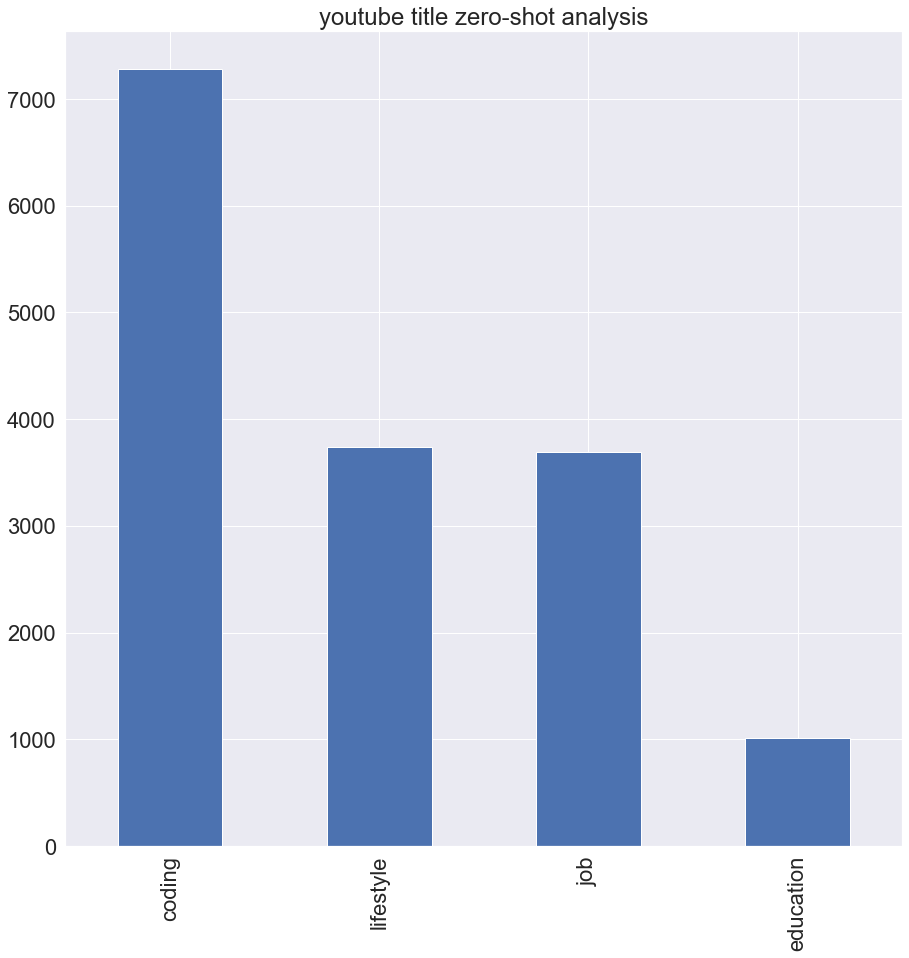

In [24]:
# Ploting of zero shot output
sns.set(rc={'figure.figsize':(15,15)})
sns.set(font_scale=2)
label = zs_title['zs_feature'].value_counts()
label.plot(kind='bar', title='youtube title zero-shot analysis')

## Prepare zeroshot output for feature engineering

In [25]:
feat_zs=zs_title.filter(['Vid_id','Title', 'zs_feature'])
# Export to dataframe
feat_zs.to_csv('./output/feat_zs.csv')

In [26]:
feat_zs.shape
feat_zs.head(3)

,Vid_id,Title,zs_feature
0,sS09Q-rKjos,Study with me videos are bad for actual learning,education
1,A3x0gYW42Ts,In Defense of Hustle Culture,lifestyle
2,egBzpILuNhA,Why the best students are NOT the most successful,education


## Merging Numerical and categorical dataset
---
The dataset from the numerical codebook in part 2 will be combined to the classification feature engineering in Part 3 and Part 4 (current codebook).
Subsequently, the top 3 content creators would be selected and recommended in this section.


In [16]:
feat_zs = pd.read_csv('./output/feat_zs.csv')
feat_zs.drop(columns=['Unnamed: 0', 'Title'], inplace=True)
feat_zs.shape
feat_zs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15718 entries, 0 to 15717
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Vid_id      15718 non-null  object
 1   zs_feature  15718 non-null  object
dtypes: object(2)
memory usage: 245.7+ KB


In [35]:
yt_df1 =pd.read_csv('./output/df_m.csv')
yt_df1.drop(columns='Unnamed: 0', inplace=True)
yt_df1.shape
yt_df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15718 entries, 0 to 15717
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Title             15718 non-null  object 
 1   Channel_name      15718 non-null  object 
 2   Vid_id            15718 non-null  object 
 3   View_count        15716 non-null  float64
 4   Like_count        15717 non-null  float64
 5   Comment_count     15718 non-null  int64  
 6   View_per_day      15716 non-null  float64
 7   Like_per_day      15717 non-null  float64
 8   Comment_per_day   15718 non-null  float64
 9   Engagement_ratio  15716 non-null  float64
 10  Popular_ratio     15715 non-null  float64
 11  Popular_target    15718 non-null  int64  
 12  Growth            15718 non-null  float64
dtypes: float64(8), int64(2), object(3)
memory usage: 1.6+ MB


In [23]:
yt_cls =pd.read_csv('./output/eda_df_tokenize_out.csv')
ytcls = yt_cls.filter(items=['Vid_id', 'topic'], axis=1)
ytcls.shape
ytcls.info()
ytcls['topic'].unique()
#

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15718 entries, 0 to 15717
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Vid_id  15718 non-null  object
 1   topic   15718 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 245.7+ KB


array([1, 2, 0, 4, 3], dtype=int64)

In [24]:
# Replace the values in the dataframe
vals_to_replace = {0: 'fullstack', 1:'learning', 2: 'coding', 3:'tools', 4:'STEM'}
ytcls['topic'] = ytcls['topic'].map(vals_to_replace)
ytcls['topic'].unique()

array(['learning', 'coding', 'fullstack', 'STEM', 'tools'], dtype=object)

<AxesSubplot:title={'center':'clustering of youtube titles'}>

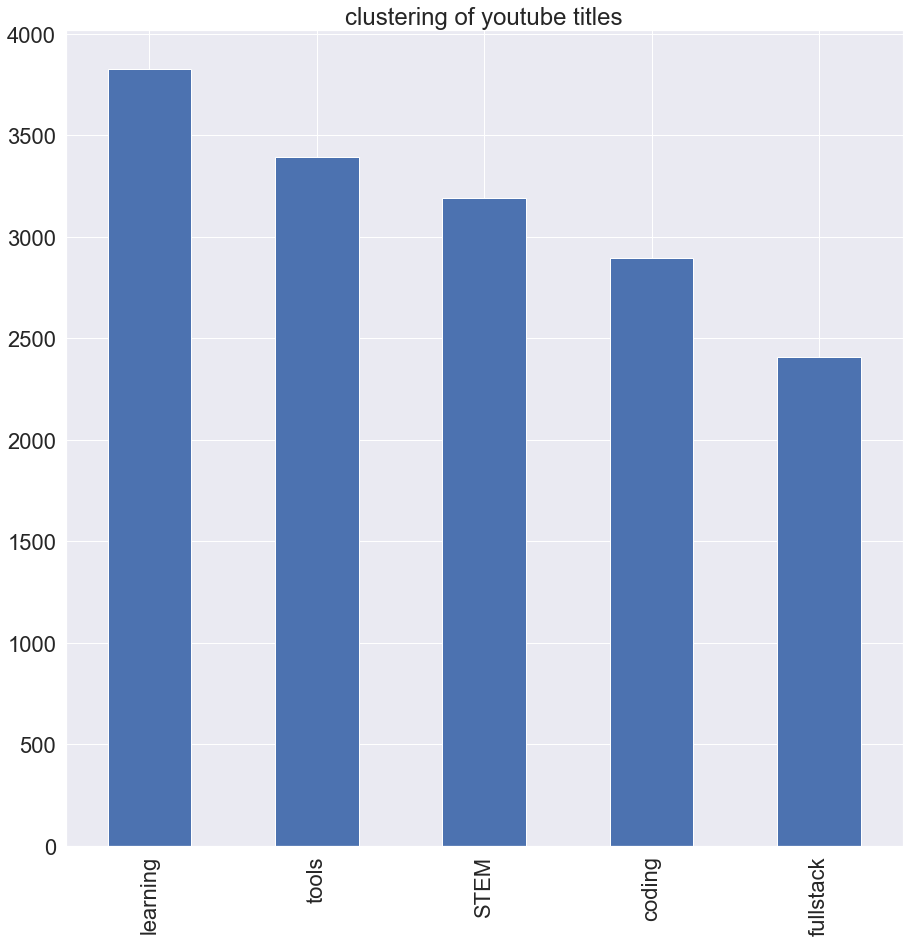

In [25]:
# Ploting of clustering output
sns.set(rc={'figure.figsize':(15,15)})
sns.set(font_scale=2)
label = ytcls['topic'].value_counts()
label.plot(kind='bar', title='clustering of youtube titles')

## Merging of the 3 dataframes

In [36]:
# Merging numerical features to zero shot features
df = pd.merge(yt_df1, feat_zs, how='inner', on = 'Vid_id')

In [37]:
# Merging clustering features
production = pd.merge(df, ytcls, how='inner', on = 'Vid_id')

In [38]:
print(production.shape)
print(production.info())
production.head(3)

(15718, 15)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 15718 entries, 0 to 15717
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Title             15718 non-null  object 
 1   Channel_name      15718 non-null  object 
 2   Vid_id            15718 non-null  object 
 3   View_count        15716 non-null  float64
 4   Like_count        15717 non-null  float64
 5   Comment_count     15718 non-null  int64  
 6   View_per_day      15716 non-null  float64
 7   Like_per_day      15717 non-null  float64
 8   Comment_per_day   15718 non-null  float64
 9   Engagement_ratio  15716 non-null  float64
 10  Popular_ratio     15715 non-null  float64
 11  Popular_target    15718 non-null  int64  
 12  Growth            15718 non-null  float64
 13  zs_feature        15718 non-null  object 
 14  topic             15718 non-null  object 
dtypes: float64(8), int64(2), object(5)
memory usage: 1.9+ MB
None


,Title,Channel_name,Vid_id,View_count,Like_count,Comment_count,View_per_day,Like_per_day,Comment_per_day,Engagement_ratio,Popular_ratio,Popular_target,Growth,zs_feature,topic
0,Study with me videos are bad for actual learning,Tina Huang,sS09Q-rKjos,16757.0,1113.0,143,9509.002236,631.587963,81.147420,0.853375,6.642000,1,36.992072,education,learning
1,In Defense of Hustle Culture,Tina Huang,A3x0gYW42Ts,46006.0,2457.0,321,3555.394838,189.879692,24.807237,0.697735,5.340608,1,36.992072,lifestyle,learning
2,Why the best students are NOT the most successful,Tina Huang,egBzpILuNhA,77435.0,4551.0,379,2985.210750,175.446428,14.610898,0.489443,5.877187,1,36.992072,education,learning


## Matching to companies 

In [39]:
# Client: Brilliant
c1 = production[(production['zs_feature']=='education')&(production['topic']=='learning')]
c1['Popular_ratio'].sort_values(ascending=False)[:10]

3222     11.851852
4041     11.245732
5686     10.253567
5108     10.089686
10596     9.239983
2316      9.174719
11646     9.149246
2366      9.131336
14172     9.062027
4122      8.689965
Name: Popular_ratio, dtype: float64

In [41]:
labels=[3222, 4041, 5686, 5108, 10596, 2316, 11646, 2366, 14172, 4122]
brilliant = pd.DataFrame(c1 , index=labels)
brilliant

,Title,Channel_name,Vid_id,View_count,Like_count,Comment_count,View_per_day,Like_per_day,Comment_per_day,Engagement_ratio,Popular_ratio,Popular_target,Growth,zs_feature,topic
3222,How to Study for the ACT and SAT (From a UChicago Grad) || ACE Your Tests and GET INTO COLLEGE!,The Almost Astrophysicist,IxFAXTblso4,270.0,32.0,12,0.377609,0.044754,0.016783,4.444444,11.851852,1,56.662506,education,learning
4041,Fastest way to get hired as a self taught web developer,Dorian Develops,zTrQfrY3rrI,9079.0,1021.0,23,302.047404,33.967441,0.765182,0.253332,11.245732,1,22.061244,education,learning
5686,2021 is gonna be LEET,John Hammond,beUAVHrepik,13527.0,1387.0,253,23.810496,2.441425,0.445336,1.870333,10.253567,1,4.617975,education,learning
5108,What I learned from Posting on YouTube for Two years,Hussein Nasser,JHYd1q0-bhs,446.0,45.0,28,0.454107,0.045818,0.028509,6.278027,10.089686,1,7.263794,education,learning
10596,holiday giveaway 🎅🏻 school supplies & stationery!,studyquill,rko6p9K4iB0,73301.0,6773.0,1317,55.310259,5.110659,0.993760,1.796701,9.239983,1,20.773201,education,learning
2316,Not Going to College: What I Wish I Knew,Nathaniel Drew,_nClrnP9LMM,128429.0,11783.0,1266,683.420537,62.701915,6.736877,0.985759,9.174719,1,34.163980,education,learning
11646,Teaching a KPOP IDOL BAND How to Draw! (The Rose),AmandaRachLee,ocVDoAY-NiA,587655.0,53766.0,1635,640.259860,58.578948,1.781360,0.278224,9.149246,1,19.989760,education,learning
2366,The Moment of Truth: Testing My Ability (Learning Portuguese part 2),Nathaniel Drew,i8kAKcpYEEQ,375542.0,34292.0,3527,467.665157,42.704075,4.392198,0.939176,9.131336,1,34.163980,education,learning
14172,How to Learn Anything | Learning Tips & Habits 🧠,Lavendaire,ezZGRBPxNmk,6610.0,599.0,31,302.645380,27.425807,1.419366,0.468986,9.062027,1,11.995868,education,learning
4122,Advice & Tips For Self Taught Programmers (as a self taught programmer),Dorian Develops,8mKOMAcoEQQ,24465.0,2126.0,148,58.937974,5.121689,0.356543,0.604946,8.689965,1,22.061244,education,learning


Thus, best youtubers to recommend to Brilliant are **The Almost Astrophysicist, Dorian Develops, John Hammond, Hussein Nasser, studyquill** for positive outreach of the brand as the popular_ratio are the highest for the field pertaining to education and learning.

In [42]:
# Client: NordVPN
c2 = production[(production['zs_feature']=='lifestyle')&(production['topic']=='fullstack')]
c2['Popular_ratio'].sort_values(ascending=False)[:10]

8229     14.340542
15188    13.145928
8178     13.002183
10203    12.202797
11497    11.847363
14197    11.828859
5815     11.318795
8130     11.273723
8207     11.227905
8214     11.124587
Name: Popular_ratio, dtype: float64

In [43]:
labels=[8229, 15188, 8178, 10203, 11497, 14197, 5815, 8130, 8207, 8214]
nordvpn = pd.DataFrame(c2 , index=labels)
nordvpn

,Title,Channel_name,Vid_id,View_count,Like_count,Comment_count,View_per_day,Like_per_day,Comment_per_day,Engagement_ratio,Popular_ratio,Popular_target,Growth,zs_feature,topic
8229,Thanksgiving giveaway,David Bombal,dlz0XmeFneU,13549.0,1943.0,1011,22.433528,3.217090,1.673946,7.461805,14.340542,1,4.171822,lifestyle,fullstack
15188,"60,000 Subscribers",ColdFusion,1UeYMl5Rgrk,7257.0,954.0,215,2.288244,0.300811,0.067793,2.962657,13.145928,1,23.127105,lifestyle,fullstack
8178,Massive 500K Giveaway,David Bombal,C9jxwi7HBnk,33902.0,4408.0,3643,68.770920,8.941721,7.389902,10.745679,13.002183,1,4.171822,lifestyle,fullstack
10203,50K Subscribers - Celebration + Giveaway,Chandoo,4K56OSVIzF0,2860.0,349.0,327,3.622837,0.442087,0.414219,11.433566,12.202797,1,19.867441,lifestyle,fullstack
11497,i’ve been to five BTS concerts & they all made me cry 🥺 #MyBTStory #ad,AmandaRachLee,JKjjATRzqRs,82339.0,9755.0,84,1887.199210,223.583336,1.925269,0.102017,11.847363,1,19.989760,lifestyle,fullstack
14197,nourish yourself like a plant 🌿,Lavendaire,WLPJPp2qfYM,11920.0,1410.0,15,183.834838,21.745564,0.231336,0.125839,11.828859,1,11.995868,lifestyle,fullstack
5815,Thankful For You,John Hammond,nQ8WmkIlKJY,2889.0,327.0,42,2.983135,0.337655,0.043369,1.453790,11.318795,1,4.617975,lifestyle,fullstack
8130,Hacking Giveaway // Be Quick!,David Bombal,LmtZCkPa_lc,44209.0,4984.0,788,133.936696,15.099651,2.387345,1.782442,11.273723,1,4.171822,lifestyle,fullstack
8207,Goodbye 2020,David Bombal,LbEg23PpP6E,17029.0,1912.0,1401,29.929656,3.360473,2.462355,8.227142,11.227905,1,4.171822,lifestyle,fullstack
8214,Christmas Giveaway Day 1,David Bombal,ScEjaKqQDwY,14841.0,1651.0,1735,25.592352,2.847044,2.991896,11.690587,11.124587,1,4.171822,lifestyle,fullstack


Thus, best youtubers to recommend to Nord VPN are **David Bombal, ColdFusion, Chandoo, AmandaRachLee and Lavendaire** for positive outreach of the brand as the popular_ratio are the highest for the field pertaining to lifestyle and fullstack.

In [46]:
# Client: The WashiShop
c3 = production[(production['zs_feature']=='lifestyle')&(production['topic']=='tools')]
c3['Popular_ratio'].sort_values(ascending=False)[:10]

14162    11.951104
14816    10.118505
14202     9.620572
14201     9.588154
12016     9.478922
2494      9.318298
9897      9.131086
2315      9.070613
7935      8.990011
14219     8.637229
Name: Popular_ratio, dtype: float64

In [47]:
labels=[14162, 14816, 14202, 14201, 12016, 2494, 9897, 2315, 7935, 14219]
washishop = pd.DataFrame(c3 , index=labels)
washishop

,Title,Channel_name,Vid_id,View_count,Like_count,Comment_count,View_per_day,Like_per_day,Comment_per_day,Engagement_ratio,Popular_ratio,Popular_target,Growth,zs_feature,topic
14162,habit stacking: easiest way to build a new habit! 💪🏼 #shorts,Lavendaire,ZUogRJ5JkBw,8426.0,1007.0,20,2966.268149,354.501783,7.040750,0.237361,11.951104,1,11.995868,lifestyle,tools
14816,How Brands Use Psychology to Make You Poor (from a marketer),Sam Lui,IS2bjijhp-w,2194.0,222.0,29,9.549132,0.966229,0.126219,1.321787,10.118505,1,83.383577,lifestyle,tools
14202,let’s go outside & be in nature 🥰🌼✨,Lavendaire,5RX1-NsLooM,11122.0,1070.0,15,141.068794,13.571625,0.190256,0.134868,9.620572,1,11.995868,lifestyle,tools
14201,go beyond small talk ✨ more honest conversations,Lavendaire,sR8ftzBieWk,12359.0,1185.0,22,160.839415,15.421531,0.286307,0.178008,9.588154,1,11.995868,lifestyle,tools
12016,The Hidden Force That Controls You,Leon Hendrix,NgCSfspuYZY,59089.0,5601.0,425,143.157443,13.569782,1.029666,0.719254,9.478922,1,174.664975,lifestyle,tools
2494,5 Lessons from Atomic Habits in Under 60 Seconds #SHORTS,Ali Abdaal,Dyliijbw_aQ,484112.0,45111.0,196,2262.599926,210.835809,0.916047,0.040486,9.318298,1,14.683795,lifestyle,tools
9897,Let Your Pain Motivate You,Dennis Ivy,yngo848avVg,130105.0,11880.0,934,174.271235,15.912857,1.251061,0.717882,9.131086,1,44.480156,lifestyle,tools
2315,Simple advice for creative people,Nathaniel Drew,S9LYW731Iqw,148259.0,13448.0,733,828.532770,75.153000,4.096308,0.494405,9.070613,1,34.163980,lifestyle,tools
7935,How To Stay Motivated When You Feel Like Giving Up,Aurelius Tjin,-vHu_5RchtQ,901.0,81.0,34,1.634775,0.146966,0.061690,3.773585,8.990011,1,18.550677,lifestyle,tools
14219,ways to level up your hydration 💧 #shorts,Lavendaire,RE5MTrZeC2c,26791.0,2314.0,26,225.908112,19.512201,0.219238,0.097048,8.637229,1,11.995868,lifestyle,tools


Thus, best youtubers to recommend to The Washi Shop are **Lavendaire, Sam Lui, leon Hendrix, Ali Abdaal and Dennis Ivy** for positive outreach of the brand as the popular_ratio are the highest for the field pertaining to lifestyle and tools.

## Conclusion and Recommendations

In conclusion, companies who are intersted in selecting content creators who are able to match their company brand. This would assist in creating more informmed decisions for partnerships. This method of creator selection can be scaled to be used for other text social networking sites as well.

Limitations and futher recommendations that can be done are:

1. Increasing the dataset from the social media by scraping. 
This is crutcial, as creators brand image can undergo and overhaul and some channels may suffer stagnating growth or loss of fanbase.

2. Other models can considered for the clustering method
As the NLP methods evlove and the dataset increas there may be more efficient methods to classify the topics.

3. More labelled dataset.
Ideally, more labelled data should be used to test and enhance the use of zero-shot for topic modelling.

In the subsequent codebook, the dataset is run through pycaret to predict the popularity of the video realsed by the creator.